In [1]:
import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np
from utils import extract_keypoints
import math

def load_image(image_path):
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def visualize_image(image):
    """
    image: an output of load_png function
    """
    plt.imshow(image)
    
def save_array_as_image(array, name):
     imageio.imwrite(name, array)

In [2]:
corner_image = load_image('results/road_nms.jpg')

In [3]:
corner_image.shape

(407, 548, 3)

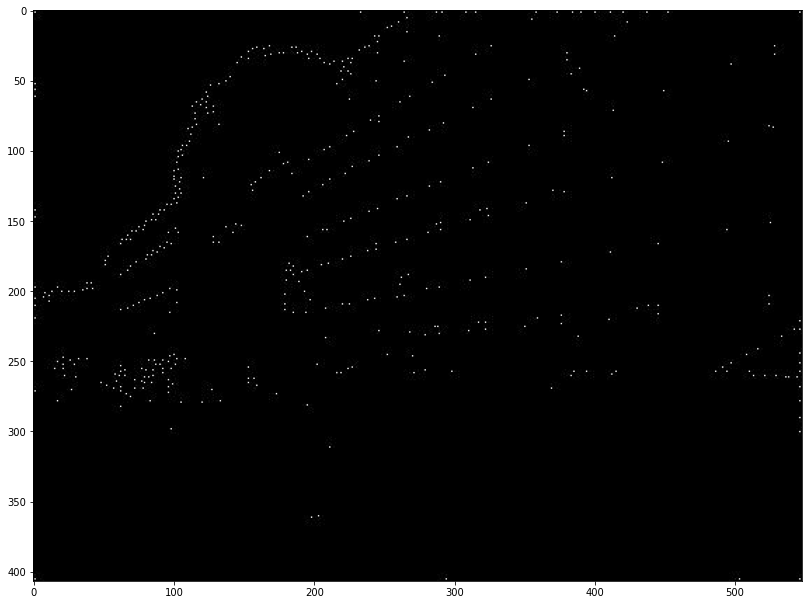

In [4]:
figure, ax = plt.subplots(1, 1)
ax.imshow(corner_image)
figure.set_size_inches(18.5, 10.5)

In [5]:
import numpy as np

def extract_keypoints(corner_image, thresh=(30,30,30)):
    indices = np.where(np.all(corner_image > thresh, axis=-1))
    return list(zip(indices[1], indices[0]))

In [6]:
keypoints = extract_keypoints(corner_image)

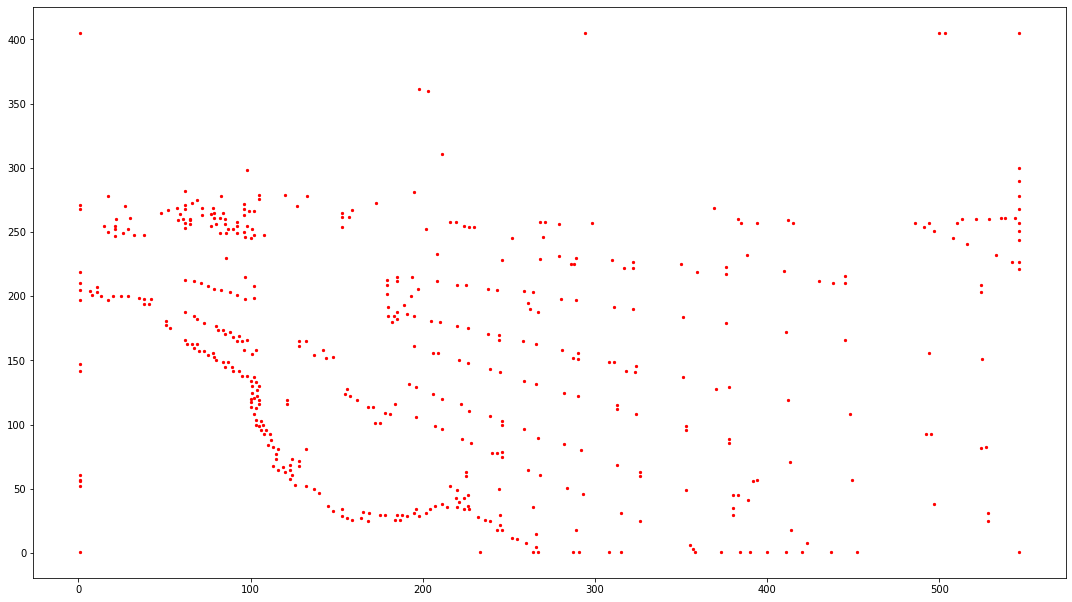

In [7]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(1, 1)
ax.scatter(np.asarray(keypoints)[:, 0], np.asarray(keypoints)[:, 1], s=5, c='r', marker = 'o')
figure.set_size_inches(18.5, 10.5)

# Hough Transform

In [8]:
class Hough:
    def __init__(self, corner_image, 
                 factor = 1,
                 threshold=(30,30,30)):
        self.corner_image = corner_image
        
        self.factor = factor
        
        self.keypoints = extract_keypoints(corner_image)
        
        self.accumulator = self.generate_accumulator()       

    def generate_accumulator(self):
        rho_bins, theta_bins = self.get_hough_accumulator_resolution(self.corner_image.shape)
        return np.zeros((rho_bins, theta_bins))
    
    def get_hough_accumulator_resolution(self, image_shape):
        
        height = image_shape[0]
        width = image_shape[1]
        
        rho_max = math.ceil((width**2 + height**2)**.5)
        num_theta_bins = math.ceil(180/math.degrees(math.atan(self.factor*1/max(width, height))))

        return rho_max, num_theta_bins
    
    def keypoint_to_image_coords(keypoint):
        x, y = keypoint
        
        h = self.corner_image.shape[0] - y
        w = x
        
        return h, w
    
    def vote(self):
        for keypoint in self.keypoints:
            for theta_unit in range(0, self.accumulator.shape[1]):
                theta = np.radians(180*theta_unit/self.accumulator.shape[1])
                x, y = keypoint
                
                rho = x*math.cos(theta) + y*math.sin(theta)
                
                self.accumulator[int(rho), theta_unit] += 1

In [16]:
hough = Hough(corner_image, factor = 0.25)
hough.vote()

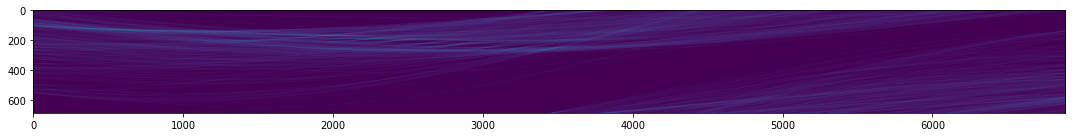

In [17]:
figure, ax = plt.subplots(1, 1)
ax.imshow(hough.accumulator)
figure.set_size_inches(18.5, 10.5)

## Vote Thresholding

In [18]:
for elem in set(list(np.ravel(hough.accumulator))):
    print(elem, list(np.ravel(hough.accumulator)).count(elem))

0.0 2783798
1.0 1044832
2.0 515209
3.0 219633
4.0 86345
5.0 32418
6.0 12476
7.0 5051
8.0 2111
9.0 978
10.0 481
11.0 215
12.0 109
13.0 59
14.0 46
15.0 19
16.0 12
17.0 13
18.0 14
19.0 2


In [19]:
vote_threshold = 13
accumulator = np.asarray(hough.accumulator > vote_threshold, dtype='int')

## Extract Lines from Accumulator

In [20]:
def extract_lines(accumulator):
    params = np.where(accumulator == 1)
    lines = list(zip(params[0], params[1]))
    return lines

def plot_line(line, acc):
    rho = line[0]
    theta = np.radians(180*line[1]/acc.shape[1])
    
    Xs = []
    Ys = []
    
    for x in range(1, 548, 10):
        if math.sin(theta) != 0:
            y = (rho - x*math.cos(theta))/math.sin(theta)
            if y < 407 and y > 0:
                Xs.append(x)
                Ys.append(y)
    
    plt.plot(Xs, Ys, linewidth = 2, c = 'red')

In [21]:
lines = extract_lines(accumulator)

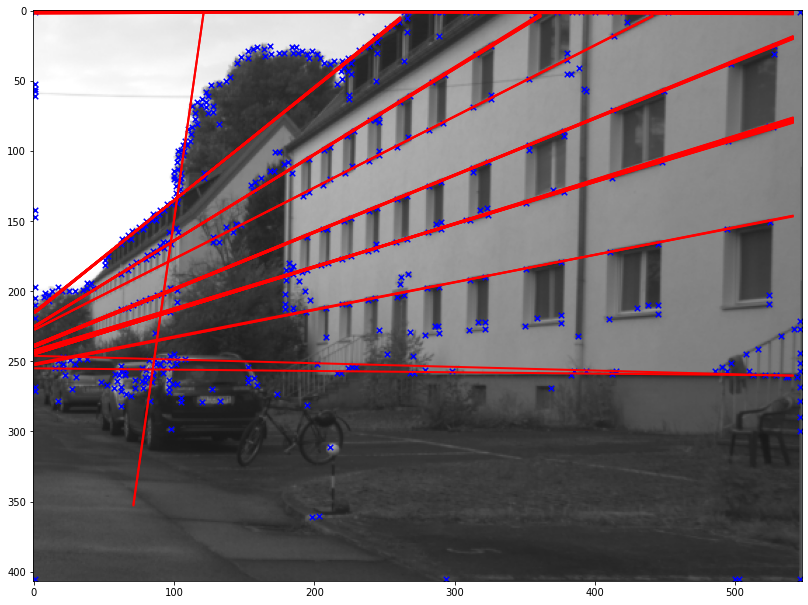

In [22]:
figure, ax = plt.subplots(1, 1)
visualize_image(load_image('road.png'))
for line in lines:
    plot_line(line, accumulator)

plt.scatter(np.asarray(keypoints)[:, 0], np.asarray(keypoints)[:, 1], s=30, c='b', marker = 'x')
figure.set_size_inches(18.5, 10.5)